In [ ]:
from google.colab import files
uploaded = files.upload()


Saving tr03-0005-arousal.mat to tr03-0005-arousal.mat
Saving tr03-0005.arousal to tr03-0005.arousal
Saving tr03-0005.hea to tr03-0005.hea
Saving tr03-0005.mat to tr03-0005.mat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
EEG shape: (5147000,)
EOG shape: (5147000,)
EMG shape: (5147000,)
Skipping invalid stage: (resp_centralapnea at index 2
Skipping invalid stage: resp_centralapnea) at index 3
Skipping invalid stage: (resp_centralapnea at index 8
Skipping invalid stage: resp_centralapnea) at index 10
Skipping invalid stage: (resp_centralapnea at index 11
Skip

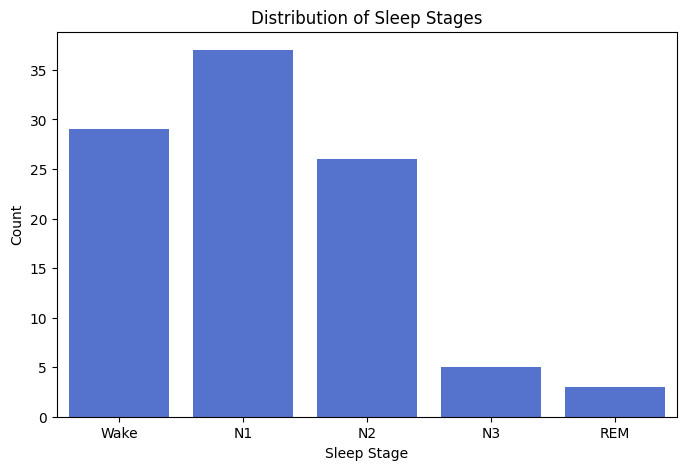

        Delta Power   Theta Power  Alpha Power  Sigma Power
Wake  234401.218750  18396.974609  7740.267090  1582.270874
N1     91692.507812   6938.503906  1809.736450   572.702515
N2     71324.179688   9921.928711  2356.661621   932.963867
N3       764.602844     63.739349    54.186562     7.243948
REM    30592.843750    256.811829   198.239929    43.975994


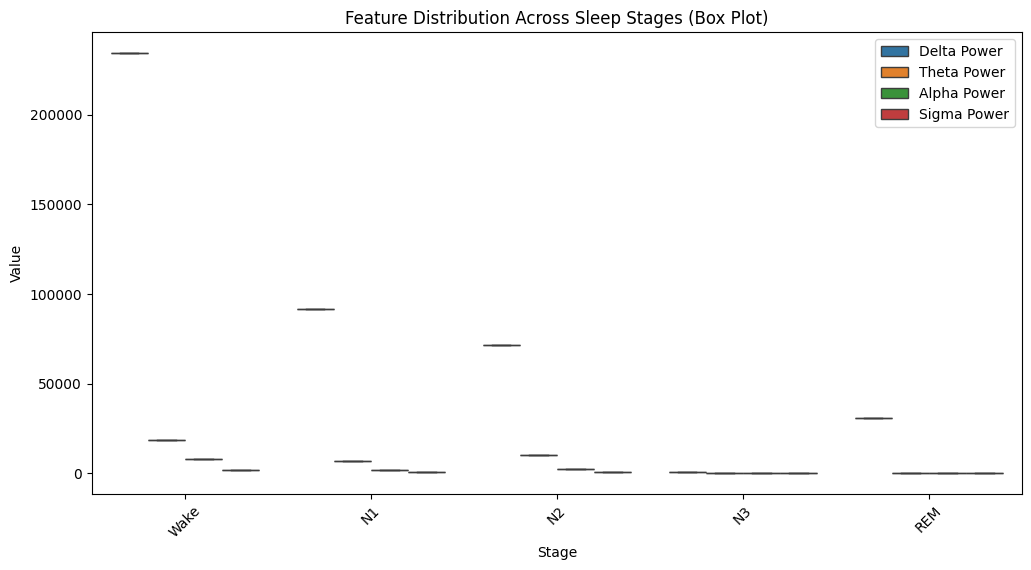

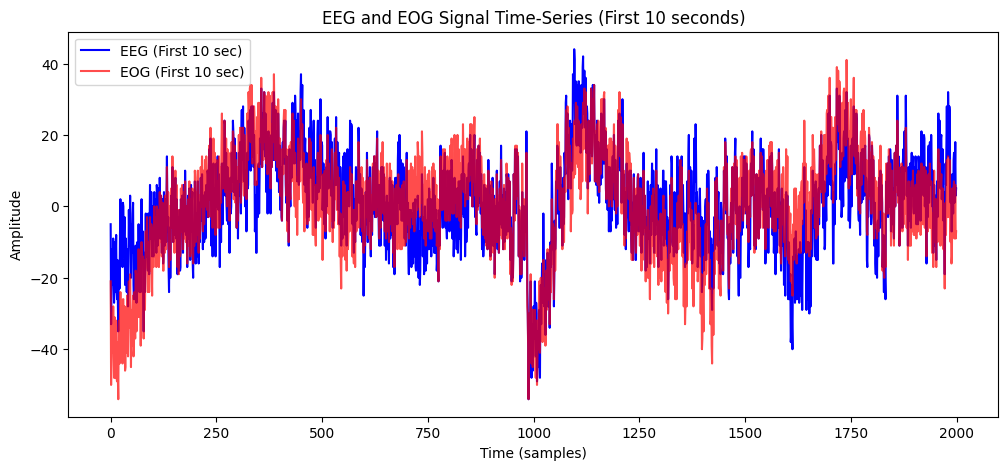

In [ ]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.signal import welch
!pip install wfdb
import wfdb
import pandas as pd

# Set global variables
fs = 200  # Sampling rate (Hz)
epoch_length = 30 * fs  # 6000 samples per epoch

### ============================
### 1. Load EEG Data from .mat File
### ============================

# Load subject data
data = loadmat("tr03-0005.mat")

# Extract EEG, EOG, and EMG signals
signal_matrix = data['val']
eeg_signal = signal_matrix[2, :]  # C3-M2 EEG
eog_signal = signal_matrix[6, :]  # E1-M2 EOG
emg_signal = signal_matrix[7, :]  # Chin1-Chin2 EMG

print("EEG shape:", eeg_signal.shape)
print("EOG shape:", eog_signal.shape)
print("EMG shape:", emg_signal.shape)

### ============================
### 2. Load Sleep Stage Annotations
### ============================

# Load annotations (sleep stages)
annotation = wfdb.rdann("tr03-0005", "arousal")

# Define valid sleep stages and handle alternative labels
stage_mapping = {
    "W": "Wake",
    "N1": "N1",
    "N2": "N2",
    "N3": "N3",
    "R": "REM",  # Map "R" to "REM"
    "REM": "REM"
}

# Initialize storage for sleep epochs
sleep_epochs = {stage: [] for stage in stage_mapping.values()}

# Extract EEG epochs per sleep stage
for i, timestamp in enumerate(annotation.sample):
    raw_label = annotation.aux_note[i]

    # Extract first valid sleep stage
    clean_label = next((stage_mapping[stage] for stage in stage_mapping if stage in raw_label.split()), None)

    if not clean_label:
        print(f"Skipping invalid stage: {raw_label} at index {i}")
        continue

    start = timestamp
    end = min(timestamp + epoch_length, len(eeg_signal))  # Avoid index error
    eeg_epoch = eeg_signal[start:end]

    if len(eeg_epoch) == epoch_length and np.isfinite(eeg_epoch).any():
        sleep_epochs[clean_label].append(eeg_epoch)
    else:
        print(f"Skipping empty or invalid segment at index {i}, Stage: {clean_label}")

# Summary of extracted epochs
for stage, segments in sleep_epochs.items():
    print(f"Stage {stage}: {len(segments)} valid epochs")

### ============================
### 3. Compute Sleep Stage Counts
### ============================

sleep_stage_counts = {stage: len(segments) for stage, segments in sleep_epochs.items()}

# Plot bar chart of sleep stage distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(sleep_stage_counts.keys()), y=list(sleep_stage_counts.values()), color="royalblue")
plt.xlabel("Sleep Stage")
plt.ylabel("Count")
plt.title("Distribution of Sleep Stages")
plt.show()

### ============================
### 4. Compute Power Spectral Density Features
### ============================

def compute_psd(signal):
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    return freqs, psd

# Initialize feature storage
features = {}

# Compute power in Delta, Theta, Alpha, Sigma bands
for stage in sleep_epochs.keys():
    stage_signals = sleep_epochs[stage]

    if not stage_signals:
        print(f"Skipping {stage} due to no valid segments.")
        continue

    delta_power, theta_power, alpha_power, sigma_power = [], [], [], []

    for segment in stage_signals:
        freqs, psd = compute_psd(segment)

        delta = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
        theta = np.sum(psd[(freqs >= 4) & (freqs < 8)])
        alpha = np.sum(psd[(freqs >= 8) & (freqs < 12)])
        sigma = np.sum(psd[(freqs >= 12) & (freqs < 14)])

        delta_power.append(delta)
        theta_power.append(theta)
        alpha_power.append(alpha)
        sigma_power.append(sigma)

    features[stage] = {
        "Delta Power": np.mean(delta_power),
        "Theta Power": np.mean(theta_power),
        "Alpha Power": np.mean(alpha_power),
        "Sigma Power": np.mean(sigma_power)
    }

# Convert features to DataFrame
df_features = pd.DataFrame(features).T
print(df_features)

### ============================
### 5. Feature Distribution Box Plot
### ============================

# Convert to long-form DataFrame
df_melted = df_features.reset_index().melt(id_vars="index", var_name="Feature", value_name="Value")
df_melted.rename(columns={"index": "Stage"}, inplace=True)

# Boxplot for feature distribution across sleep stages
plt.figure(figsize=(12, 6))
sns.boxplot(x="Stage", y="Value", hue="Feature", data=df_melted)
plt.xticks(rotation=45)
plt.title("Feature Distribution Across Sleep Stages (Box Plot)")
plt.legend(loc="upper right")
plt.show()

### ============================
### 6. EEG and EOG Signal Time-Series Plot
### ============================

# Select first 10 seconds of EEG and EOG from N2 and REM sleep
plt.figure(figsize=(12, 5))
plt.plot(eeg_signal[:fs * 10], label="EEG (First 10 sec)", color="blue")
plt.plot(eog_signal[:fs * 10], label="EOG (First 10 sec)", color="red", alpha=0.7)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("EEG and EOG Signal Time-Series (First 10 seconds)")
plt.legend()
plt.show()


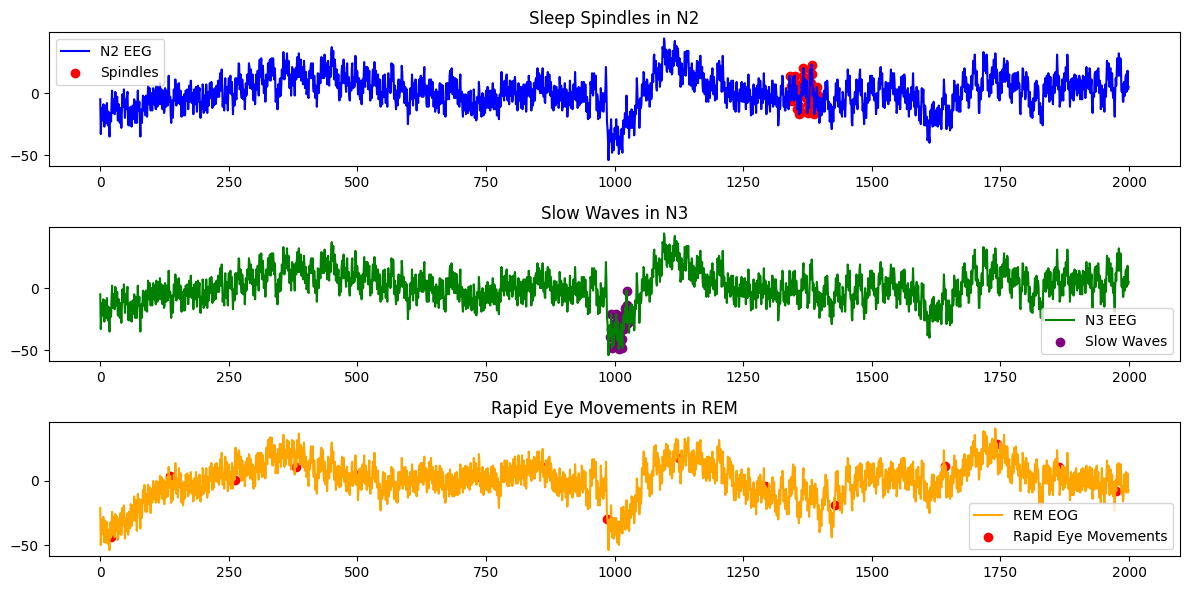

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# Function to bandpass filter the EEG signal
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Detect sleep spindles in N2 stage
def detect_spindles(eeg_signal, fs):
    filtered_signal = bandpass_filter(eeg_signal, 12, 14, fs)
    envelope = np.abs(hilbert(filtered_signal))  # Compute signal envelope
    threshold = np.mean(envelope) + 3 * np.std(envelope)  # 3x std threshold
    spindle_indices = np.where(envelope > threshold)[0]
    return spindle_indices

# Detect slow waves in N3 stage
def detect_slow_waves(eeg_signal, fs):
    filtered_signal = bandpass_filter(eeg_signal, 0.5, 4, fs)
    threshold = np.mean(filtered_signal) - 3 * np.std(filtered_signal)  # Large negative peaks
    slow_wave_indices = np.where(filtered_signal < threshold)[0]
    return slow_wave_indices

# Detect REM eye movements in EOG
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d

def detect_rem_movements(eog_signal, fs):
    """
    Detect rapid eye movements (REMs) in EOG using derivative & peak detection.

    Parameters:
    - eog_signal: 1D array of EOG signal
    - fs: Sampling frequency (Hz)

    Returns:
    - rem_indices: Indices of detected REM movements
    """
    # Step 1: Smooth the signal to reduce noise
    smooth_eog = uniform_filter1d(eog_signal, size=5)  # Moving average filter

    # Step 2: Compute first derivative (rate of change)
    diff_eog = np.diff(smooth_eog)

    # Step 3: Adaptive thresholding (95th percentile)
    threshold = np.percentile(np.abs(diff_eog), 95)

    # Step 4: Find points where derivative crosses threshold
    rem_indices, _ = find_peaks(np.abs(diff_eog), height=threshold, distance=fs // 2)

    return rem_indices + 1  # Adjust for np.diff() shift


# Apply detection to example signals
fs = 200  # Sampling frequency
n2_eeg = eeg_signal[:2000]  # Example segment
n3_eeg = eeg_signal[:2000]
rem_eog = eog_signal[:2000]

spindles = detect_spindles(n2_eeg, fs)
slow_waves = detect_slow_waves(n3_eeg, fs)
rem_movements = detect_rem_movements(rem_eog, fs)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(n2_eeg, label="N2 EEG", color="blue")
plt.scatter(spindles, n2_eeg[spindles], color="red", label="Spindles", marker="o")
plt.legend()
plt.title("Sleep Spindles in N2")

plt.subplot(3, 1, 2)
plt.plot(n3_eeg, label="N3 EEG", color="green")
plt.scatter(slow_waves, n3_eeg[slow_waves], color="purple", label="Slow Waves", marker="o")
plt.legend()
plt.title("Slow Waves in N3")

plt.subplot(3, 1, 3)
plt.plot(rem_eog, label="REM EOG", color="orange")
plt.scatter(rem_movements, rem_eog[rem_movements], color="red", label="Rapid Eye Movements", marker="o")
plt.legend()
plt.title("Rapid Eye Movements in REM")

plt.tight_layout()
plt.show()


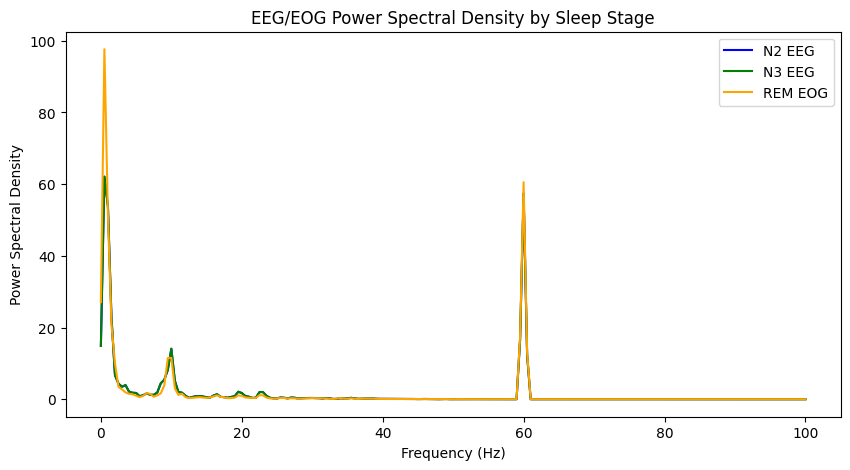

In [ ]:
from scipy.signal import welch

# Function to compute power spectral density
def compute_psd(signal, fs):
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    return freqs, psd

# Example: Compute PSD for N2, N3, and REM EEG
n2_freqs, n2_psd = compute_psd(n2_eeg, fs)
n3_freqs, n3_psd = compute_psd(n3_eeg, fs)
rem_freqs, rem_psd = compute_psd(rem_eog, fs)

# Plot PSD
plt.figure(figsize=(10, 5))

plt.plot(n2_freqs, n2_psd, label="N2 EEG", color="blue")
plt.plot(n3_freqs, n3_psd, label="N3 EEG", color="green")
plt.plot(rem_freqs, rem_psd, label="REM EOG", color="orange")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("EEG/EOG Power Spectral Density by Sleep Stage")
plt.legend()
plt.show()


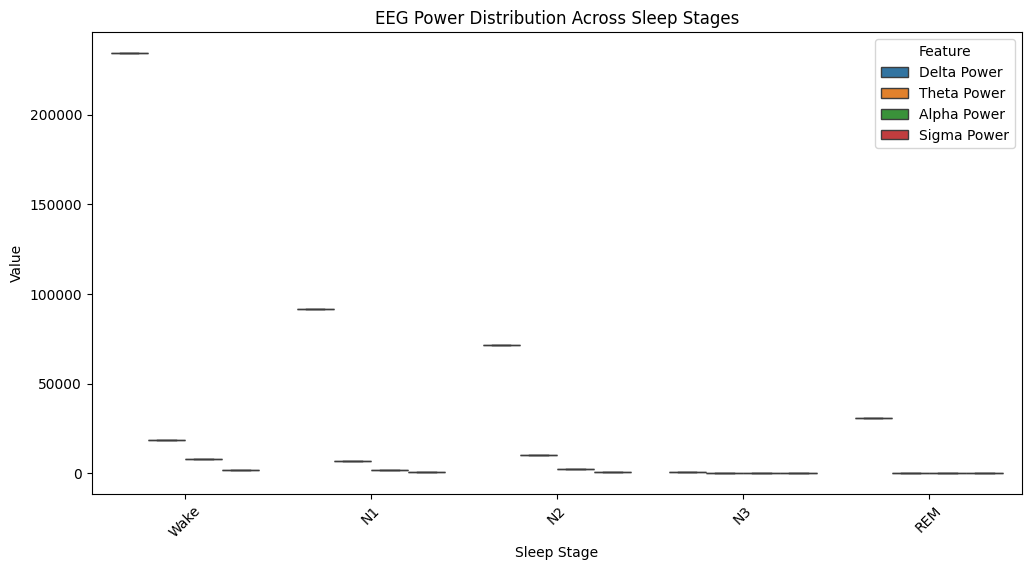

In [ ]:
import pandas as pd
import seaborn as sns

# Prepare a DataFrame
features_df = pd.DataFrame.from_dict(features, orient='index')
features_df = features_df.dropna()

# Melt DataFrame for visualization
features_melted = features_df.melt(ignore_index=False).reset_index()
features_melted.columns = ["Sleep Stage", "Feature", "Value"]

# Box plot to compare power across sleep stages
plt.figure(figsize=(12, 6))
sns.boxplot(x="Sleep Stage", y="Value", hue="Feature", data=features_melted)
plt.xticks(rotation=45)
plt.title("EEG Power Distribution Across Sleep Stages")
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram

# Convert sleep epochs into numpy arrays
X = []
y = []

for stage, segments in sleep_epochs.items():
    for segment in segments:
        # Convert EEG signal into a spectrogram (Time-Frequency Representation)
        f, t, Sxx = spectrogram(segment, fs=200, nperseg=256, noverlap=128)
        X.append(Sxx)
        y.append(stage)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Normalize the spectrograms
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Encode labels
stage_mapping = {"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4}
y = np.array([stage_mapping[label] for label in y])
y = to_categorical(y, num_classes=5)  # One-hot encoding

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input (batch, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (80, 129, 45, 1)
Testing data shape: (20, 129, 45, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape

# Define the CNN-LSTM model
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Reshape((-1, 128)),  # Reshape for LSTM input

    # LSTM layer
    LSTM(64, return_sequences=False),

    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 sleep stages
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 129, 45, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 5, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 80, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,565 (572.52 KB)

 Trainable params: 146,565 (572.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3070 - loss: 1.6077 - val_accuracy: 0.3500 - val_loss: 1.5959
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 893ms/step - accuracy: 0.3414 - loss: 1.5938 - val_accuracy: 0.3500 - val_loss: 1.5678
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2891 - loss: 1.5687 - val_accuracy: 0.3500 - val_loss: 1.5021
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.3430 - loss: 1.5060 - val_accuracy: 0.3500 - val_loss: 1.3778
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.3625 - loss: 1.4446 - val_accuracy: 0.3500 - val_loss: 1.3051
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.3633 - loss: 1.3930 - val_accuracy: 0.3500 - val_loss: 1.2774
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.3484 - loss: 1.3973 - val_accuracy: 0.3500 - val_loss: 1.2990
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 0.3297 - loss: 1.3777 - val_accuracy: 0.3500 - val_loss: 1.296

In [ ]:
from scipy.stats import entropy

# Function to compute spectral entropy
def spectral_entropy(psd):
    psd_norm = psd / np.sum(psd)  # Normalize PSD
    return entropy(psd_norm)

# Example: Compute spectral entropy for a segment
f, psd = compute_psd(eeg_signal[:6000], fs=200)
spec_entropy = spectral_entropy(psd)

print("Spectral Entropy:", spec_entropy)


Spectral Entropy: 3.1418328


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), np.argmax(y_train, axis=1))

# Evaluate
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
acc = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("RandomForest Accuracy:", acc)


RandomForest Accuracy: 0.5


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tr03-0029.mat to tr03-0029.mat
Saving tr03-0052.mat to tr03-0052.mat
Saving tr03-0061.mat to tr03-0061.mat
Saving tr03-0078.mat to tr03-0078.mat
Saving tr03-0079.mat to tr03-0079.mat
Saving tr03-0083.mat to tr03-0083.mat
Saving tr03-0086.mat to tr03-0086.mat


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tr03-0029.arousal to tr03-0029.arousal
Saving tr03-0052.arousal to tr03-0052.arousal
Saving tr03-0061.arousal to tr03-0061 (1).arousal
Saving tr03-0078.arousal to tr03-0078 (1).arousal
Saving tr03-0079.arousal to tr03-0079 (1).arousal
Saving tr03-0083.arousal to tr03-0083 (1).arousal
Saving tr03-0086.arousal to tr03-0086 (1).arousal


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import welch
import wfdb

# Set global variables
fs = 200  # Sampling rate (Hz)
epoch_length = 30 * fs  # 6000 samples = 30 seconds
record_ids = ['tr03-0005', 'tr03-0029','tr03-0052', 'tr03-0061', 'tr03-0078','tr03-0079','tr03-0083','tr03-0086']  # Add more as needed

# Sleep stage mapping
stage_mapping = {
    "W": "Wake",
    "N1": "N1",
    "N2": "N2",
    "N3": "N3",
    "R": "REM",
    "REM": "REM"
}

# PSD computation helper
def compute_psd(signal):
    freqs, psd = welch(signal, fs, nperseg=fs*2)
    return freqs, psd

# Initialize master feature list
all_features = []

for record_id in record_ids:
    try:
        print(f"Processing {record_id}...")

        # Load .mat signal file
        mat_file = f"{record_id}.mat"
        data = loadmat(mat_file)
        eeg_signal = data['val'][2, :]  # EEG channel (C3-M2)

        # Load annotations
        annotation = wfdb.rdann(record_id, "arousal")

        for i, timestamp in enumerate(annotation.sample):
            raw_label = annotation.aux_note[i]
            clean_label = next((stage_mapping[stage] for stage in stage_mapping if stage in raw_label.split()), None)

            if not clean_label:
                continue  # Skip invalid or unrecognized labels

            start = timestamp
            end = min(timestamp + epoch_length, len(eeg_signal))

            eeg_epoch = eeg_signal[start:end]

            if len(eeg_epoch) != epoch_length or not np.isfinite(eeg_epoch).any():
                continue

            # Compute PSD features
            freqs, psd = compute_psd(eeg_epoch)
            delta = np.sum(psd[(freqs >= 0.5) & (freqs < 4)])
            theta = np.sum(psd[(freqs >= 4) & (freqs < 8)])
            alpha = np.sum(psd[(freqs >= 8) & (freqs < 12)])
            sigma = np.sum(psd[(freqs >= 12) & (freqs < 14)])

            all_features.append({
                "Record": record_id,
                "Stage": clean_label,
                "Delta Power": delta,
                "Theta Power": theta,
                "Alpha Power": alpha,
                "Sigma Power": sigma
            })

    except Exception as e:
        print(f"⚠️ Error processing {record_id}: {e}")

# Create DataFrame
df_all_features = pd.DataFrame(all_features)
print(f"\n✅ Aggregated feature set: {df_all_features.shape[0]} epochs")
print(df_all_features["Stage"].value_counts())
df_all_features.head()


Processing tr03-0005...
Processing tr03-0029...
Processing tr03-0052...
Processing tr03-0061...
Processing tr03-0078...
Processing tr03-0079...
Processing tr03-0083...
Processing tr03-0086...

✅ Aggregated feature set: 958 epochs
Stage
N1      329
N2      313
Wake    179
N3       91
REM      46
Name: count, dtype: int64


,Record,Stage,Delta Power,Theta Power,Alpha Power,Sigma Power
0,tr03-0005,Wake,831607.812500,38491.937500,16775.132812,3577.520996
1,tr03-0005,N1,44.669796,23.713257,30.531910,6.601441
2,tr03-0005,Wake,25.402128,11.297466,41.852951,4.684117
3,tr03-0005,N1,31.264786,17.945705,35.815346,6.841299
4,tr03-0005,N2,108.316956,21.961647,14.482639,6.980826


from matplotlib import pyplot as plt
_df_0['Delta Power'].plot(kind='hist', bins=20, title='Delta Power')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Theta Power'].plot(kind='hist', bins=20, title='Theta Power')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Alpha Power'].plot(kind='hist', bins=20, title='Alpha Power')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Sigma Power'].plot(kind='hist', bins=20, title='Sigma Power')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Delta Power', y='Theta Power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Theta Power', y='Alpha Power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Alpha Power', y='Sigma Power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Delta Power'].plot(kind='line', figsize=(8, 4), title='Delta Power')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Theta Power'].plot(kind='line', figsize=(8, 4), title='Theta Power')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Alpha Power'].plot(kind='line', figsize=(8, 4), title='Alpha Power')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Sigma Power'].plot(kind='line', figsize=(8, 4), title='Sigma Power')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='Delta Power', y='Stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Theta Power', y='Stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Alpha Power', y='Stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Sigma Power', y='Stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
df = df_all_features.copy()
valid_stage_counts = df["Stage"].value_counts()
valid_stages = valid_stage_counts[valid_stage_counts >= 2].index.tolist()
df = df[df["Stage"].isin(valid_stages)]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Stage_encoded"] = le.fit_transform(df["Stage"])

X = df[["Delta Power", "Theta Power", "Alpha Power", "Sigma Power"]]
y = df["Stage_encoded"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


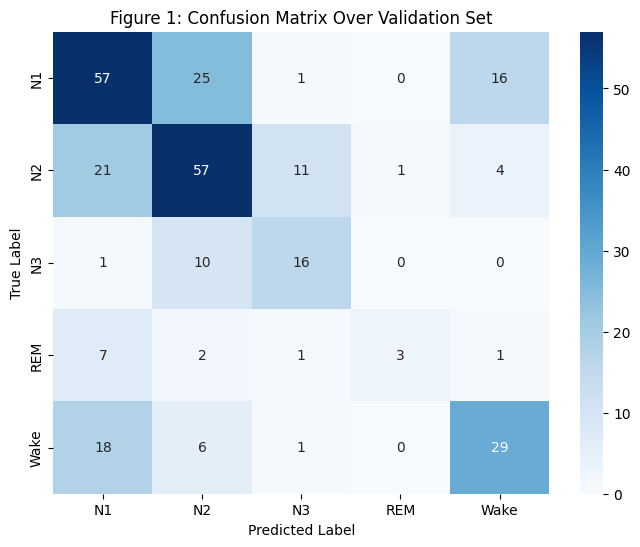

Table 1: Cross-Validation Performance Metrics

              precision    recall  f1-score   support

          N1       0.55      0.58      0.56        99
          N2       0.57      0.61      0.59        94
          N3       0.53      0.59      0.56        27
         REM       0.75      0.21      0.33        14
        Wake       0.58      0.54      0.56        54

    accuracy                           0.56       288
   macro avg       0.60      0.51      0.52       288
weighted avg       0.57      0.56      0.56       288



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Figure 1: Confusion Matrix Over Validation Set")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("Table 1: Cross-Validation Performance Metrics\n")
print(report)


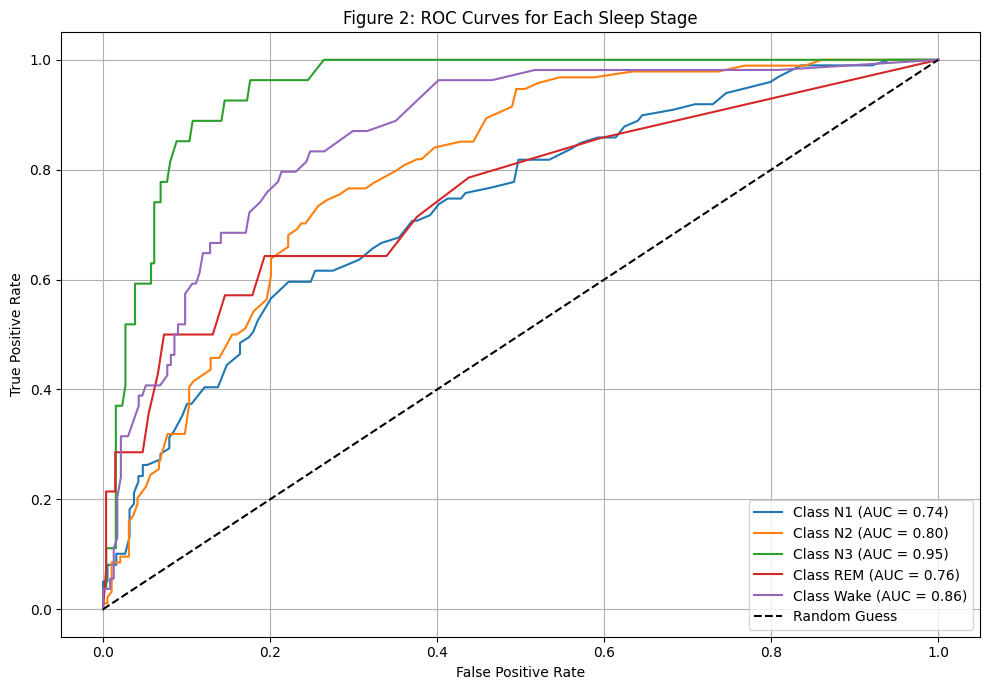

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize true labels (multi-class → one-hot)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Get class probabilities from the model
y_score = clf.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {le.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 2: ROC Curves for Each Sleep Stage")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## LSTM Model for Sleep Stage Classification

In [ ]:
# Assuming `X` is your features and `y` is your target
# Ensure X is 3D: (samples, timesteps, features)
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Example reshaping for LSTM - modify as needed based on your actual feature shape
timesteps = 10  # number of time steps (e.g., windowed EEG segments)
features = X.shape[1] // timesteps
X_lstm = X.reshape((X.shape[0], timesteps, features))

# Encode labels
y_encoded = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')